In [ ]:
%load_ext autoreload
%autoreload 2

from FP567_Lib import *

import tensorflow as tf
import json
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
# Get the info of the model we want to load
model_month = "12"
model_day = "11"
model_time = "18:20:13"
PATH_TO_MODEL_INFO = os.path.join(
    PATH_TO_MODELS_DIRECTORY,
    model_month,
    model_day,
    model_time)

# save_at_n.hf files are to big to push to github
PATH_TO_WEIGHTS_TO_LOAD = os.path.join(PATH_TO_MODEL_INFO, "VL_0073.h5")
PATH_TO_JSON_PARAMS = os.path.join(PATH_TO_MODEL_INFO, TRAINING_PARAMS_JSON)
print("Path to weights:", PATH_TO_WEIGHTS_TO_LOAD)

Path to weights: /home/michael/Desktop/UNM Fall 2022/BigData/567FP/CS567_Final_Proj/models/12/11/18:20:13/VL_0073.h5


In [3]:
if not (os.path.exists(PATH_TO_JSON_PARAMS) and os.path.exists(PATH_TO_WEIGHTS_TO_LOAD)):
    raise Exception("Requested model info does not exist.")

params_dict = json.load(open(PATH_TO_JSON_PARAMS))
predict_size = int(params_dict[PREDICT_SIZE_STR])
number_of_market_items = int(params_dict[NUMBER_ITEMS_PREDICTED_STR])
window_size = int(params_dict[TIME_WINDOW_SIZE_STR])
batch_size = int(params_dict[BATCH_SIZE_STR])

In [4]:
model = get_model((number_of_market_items, window_size), 1, predict_size)
model.load_weights(PATH_TO_WEIGHTS_TO_LOAD)

In [5]:
# the final 10% of z is testing data that our model has never seen
z, forcasting_specs = read_saved_forcasting_matrix()
forcasted_day_len = forcasting_specs[FORCASTED_DAY_LEN_STR]

total_days = z.shape[1]/forcasted_day_len

num_testing_days = total_days - int(total_days*0.1)

testing_cols_start = int(num_testing_days*forcasted_day_len)
testing_days = z[:, testing_cols_start:]

In [6]:
# scale to match the way we trained, but also for better plots at the end
scaler = StandardScaler()
testing_days = scaler.fit(testing_days).fit_transform(testing_days)

In [7]:
# lets grab windows from the testing data, predict on them
preds_gatherer = PriceAndAmountSoldGatherer()
true_prices = testing_days[:,(forcasted_day_len-1)::forcasted_day_len] 
true_amount_solds = testing_days[:,(forcasted_day_len-2)::forcasted_day_len]

def predict_and_gather(i, days_mat, window_start, window_end, predict_window_end, preds_gatherer):
    '''
    Used in window_slider below to predict and accumulate the amount solds and prices
    '''
    instance = days_mat[:, window_start:window_end]
    instance = np.array([instance])
    #print(instance.shape)
    prediction = model.predict(instance)[0]
    #print(prediction)
    preds_gatherer.add_price_pred(prediction[:, (forcasted_day_len-1)::forcasted_day_len])
    #pred_prices = np.hstack([pred_prices, )
    preds_gatherer.add_a_s_pred(prediction[:, (forcasted_day_len-2)::forcasted_day_len])
    #pred_amount_solds = np.hstack([pred_amount_solds, prediction[:, (forcasted_day_len-2)::forcasted_day_len]])

In [ ]:
window_slider(predict_size, window_size, testing_days, predict_and_gather, preds_gatherer)

In [13]:
pred_prices = preds_gatherer.get_price_preds_mat()
pred_a_s = preds_gatherer.get_a_s_preds_mat()
filtered_true_prices = true_prices[:, true_prices.shape[1]-pred_prices.shape[1]:]
filtered_true_a_s = true_amount_solds[:, true_amount_solds.shape[1]-pred_a_s.shape[1]:]

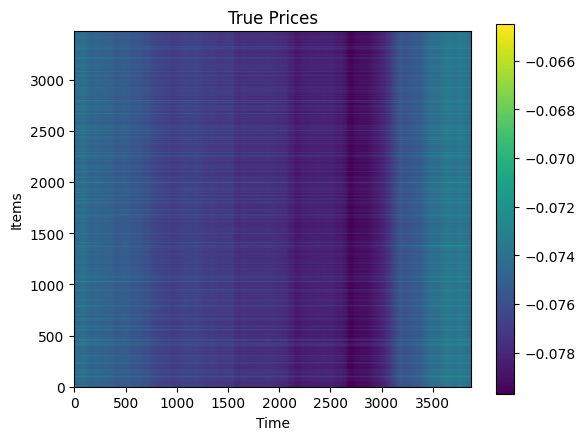

In [63]:
is_outliers = filtered_true_prices.mean(axis=1) < -0.07
not_outliers = filtered_true_prices[is_outliers]
plt.clf()
plt.title("True Prices")
plt.ylabel("Items")
plt.xlabel("Time")
plt.imshow(
    not_outliers,
    origin="lower",
    extent=[0, number_of_market_items, 0, len(not_outliers)])
plt.colorbar()
plt.show()

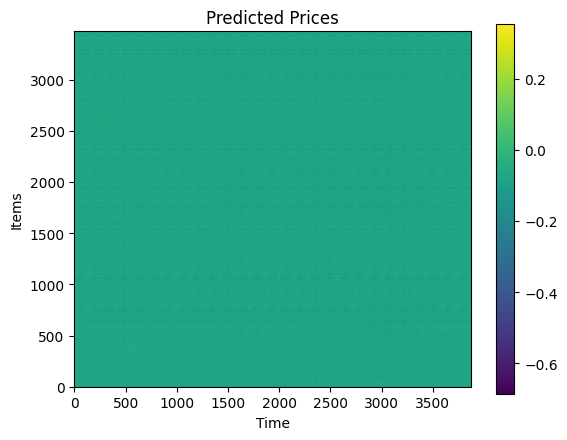

In [67]:
plt.clf()
plt.title("Predicted Prices")
plt.ylabel("Items")
plt.xlabel("Time")
plt.imshow(
    pred_prices[is_outliers],
    origin="lower",
    extent=[0, number_of_market_items, 0, len(not_outliers)])
plt.colorbar()
plt.show()

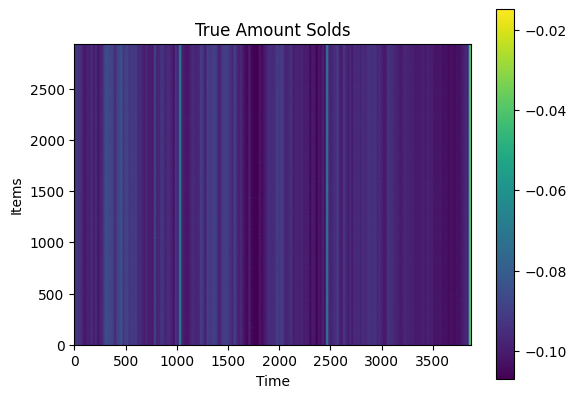

In [56]:
is_outliers = filtered_true_a_s.mean(axis=1) < -0.095
not_outliers = filtered_true_a_s[is_outliers]
plt.clf()
plt.title("True Amount Solds")
plt.ylabel("Items")
plt.xlabel("Time")
plt.imshow(
    not_outliers,
    origin="lower",
    extent=[0, number_of_market_items, 0, len(not_outliers)])
plt.colorbar()
plt.show()

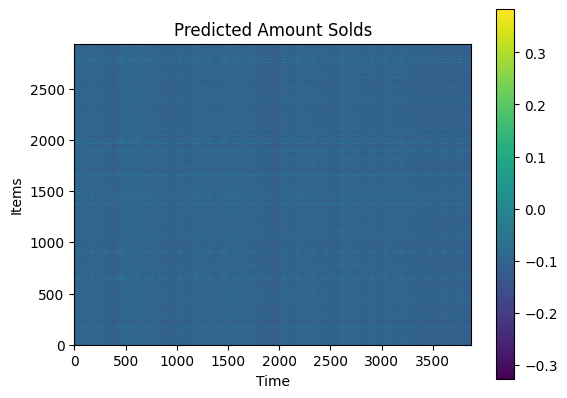

In [59]:
plt.clf()
plt.title("Predicted Amount Solds")
plt.ylabel("Items")
plt.xlabel("Time")
plt.imshow(
    pred_a_s[is_outliers],
    origin="lower",
    extent=[0, number_of_market_items, 0, len(not_outliers)])
plt.colorbar()
plt.show()

In [68]:
# Lets get, for each item, a mean error for the prices and amount solds, then plot them
mean_price_err = np.abs(filtered_true_prices - pred_prices).mean(axis=1)
mean_amount_sold_err = np.abs(filtered_true_a_s - pred_a_s).mean(axis=1)

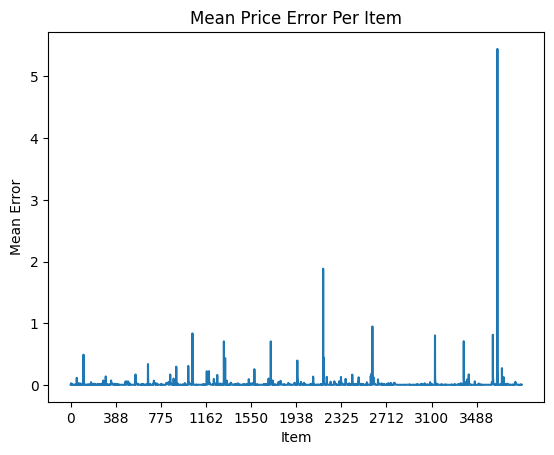

In [69]:
plt.clf()
plt.title("Mean Price Error Per Item")
plt.ylabel("Mean Error")
plt.xlabel("Item")
plt.plot(mean_price_err)
plt.xticks(np.arange(0, len(mean_price_err), step=len(mean_price_err)/10))
plt.show()

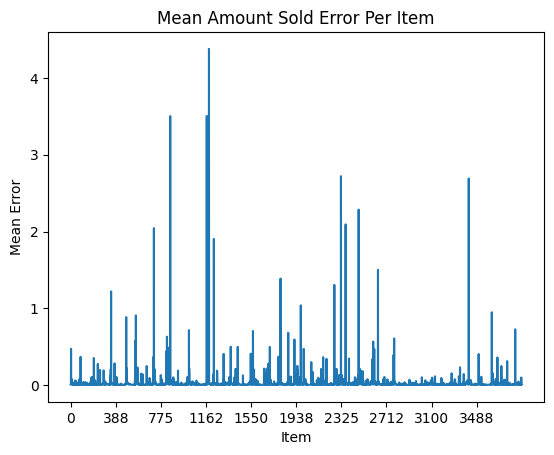

In [70]:
plt.clf()
plt.title("Mean Amount Sold Error Per Item")
plt.ylabel("Mean Error")
plt.xlabel("Item")
plt.plot(mean_amount_sold_err)
plt.xticks(np.arange(0, len(mean_amount_sold_err), step=len(mean_amount_sold_err)/10))
plt.show()

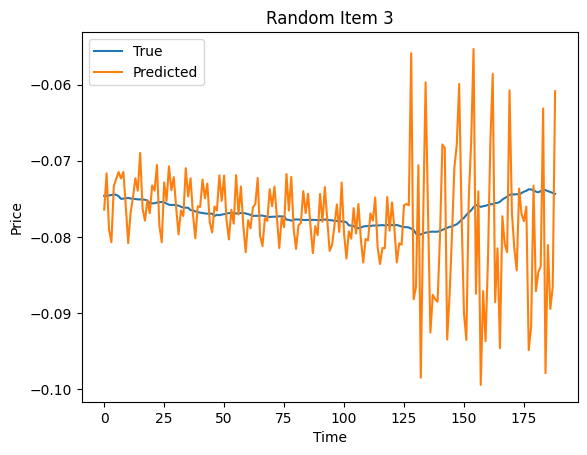

In [108]:
random_i = random.randint(0, number_of_market_items-1)
plt.clf()
plt.title("Random Item 3")
plt.xlabel("Time")
plt.ylabel("Price")
plt.plot(filtered_true_prices[random_i], label="True")
plt.plot(pred_prices[random_i], label="Predicted")
plt.legend()
plt.show()